<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Reproducibility

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(123)
import random as rn
rn.seed(123)

### Libraries

In [4]:
!pip install text-preprocessing
!pip install tweet-preprocessor
!pip install -U nltk[twitter]
!pip install joblib

Requirement already up-to-date: nltk[twitter] in /usr/local/lib/python3.7/dist-packages (3.6.2)


In [5]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from sklearn import utils
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [6]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [7]:
# upload here the .csv file "labeled_data.csv"
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [8]:
# read the csv file, select the columns of interest, and rename them
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [9]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
# size of the dataset
raw.shape

(24783, 3)

In [11]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


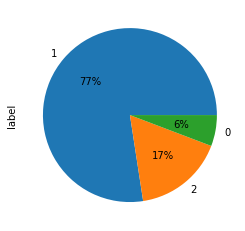

In [12]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Preprocessing text

In [13]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left out because they could contain hate speech to detect
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(raw['cleaned'], raw['label'], test_size=0.1, random_state=123)

### Doc2vec Custom Transformer

In [ ]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, dm=1, size=1, window=1):
        self.d2v_model = None
        self.size = size
        self.window = window
        self.dm = dm

    def fit(self, raw_documents, y=None):
        # Initialize model
        self.d2v_model = Doc2Vec(workers=1, seed=123)
        # Tag docs
        tagged_documents = []
        for index, row in raw_documents.iteritems():
            tag = '{}_{}'.format("type", index)
            tokens = row.split()
            tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))
        # Build vocabulary
        self.d2v_model.build_vocab(tagged_documents)
        # Train model
        self.d2v_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=self.d2v_model.epochs)
        return self

    def transform(self, raw_documents):
        X = []
        for index, row in raw_documents.iteritems():
            X.append(self.d2v_model.infer_vector(row))
        X = pd.DataFrame(X, index=raw_documents.index)
        return X
        
    def fit_transform(self, raw_documents, y=None):
        self.fit(raw_documents)
        return self.transform(raw_documents)

### Sentiment Custom Transformer

In [18]:
class SentimentTransformer( BaseEstimator, TransformerMixin ):
    
    # Class Constructor 
    def __init__( self ):
        return
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
        
    # Method that describes what we need this transformer to do i.e.
    # returning length, digits and punctuations in the 'text' column in data frame
    def transform( self, X, y = None ):
      sia = SentimentIntensityAnalyzer()

      f           = pd.DataFrame()
      f['neg']    = [sia.polarity_scores(x)['neg'] for x in X]
      f['neu']    = [sia.polarity_scores(x)['neu'] for x in X]
      f['pos']    = [sia.polarity_scores(x)['pos'] for x in X]
      return f[['neg','neu','pos']]

### Dense Transformer

In [19]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()